In [1]:
from direct_integration import get_A_omega, compute_memory_kernel, generate_noise, run_twa_bundle
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import jax

W0208 18:48:47.424156    5175 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0208 18:48:47.426450    5073 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


# Spin Test

In [2]:
trajectories = int(1e4)
t_max = 10
dt = 0.001  
t_grid = jnp.arange(0, t_max, dt)
eta = 1.0
omega_c = 4.0
kbt = 1.0
g = 1.0
b_field = jnp.array([0.0, 0.0, 0.0])  
initial_state = jnp.array([1.0, 0.0, 1.0]) 
width_scale = 0.0

key = jax.random.PRNGKey(2026)
keys = jax.random.split(key, trajectories)

    
def ohmic():
    return run_twa_bundle(keys, t_grid, eta, omega_c, 1.0, kbt, b_field, g, initial_state, width_scale, int(trajectories/5))

def sub_ohmic():
    return run_twa_bundle(keys, t_grid, eta, omega_c, 0.3, kbt, b_field, g, initial_state, width_scale, int(trajectories/5))

def super_ohmic():
    return run_twa_bundle(keys, t_grid, eta, omega_c, 2.0, kbt, b_field, g, initial_state, width_scale, int(trajectories/5))

In [3]:
mean_ohmic_trace = ohmic()
mean_sub_ohmic_trace = sub_ohmic()
mean_super_ohmic_trace = super_ohmic()

Simulating TWA Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Simulating TWA Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Simulating TWA Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
def compute_exact_expectation_value(t_grid, initial_state, eta, omega_c, s, kBT, g, num_omega=10000):
    """
    Calculates the Exact Quantum Mechanical Expectation Value <Sx(t)>
    for the Pure Dephasing Spin-Boson model (B=0).
    
    Returns:
        sx_t, sy_t, sz_t: Arrays of expectation values.
    """
    # 1. Normalize Initial State
    S0 = jnp.array(initial_state)
    norm = jnp.linalg.norm(S0)
    sx0, sy0, sz0 = S0 / norm
    
    # 2. Frequency Grid
    # High resolution to capture spectral density features
    omega = jnp.linspace(1e-5, 50.0 * omega_c, num_omega)
    
    # 3. Spectral Density A(w)
    # Using the definition from your PDF Eq. (30) & (35)
    # J(w) = eta * w * (w/wc)^(s-1) * exp(-w/wc) * (pi/2) ??
    # Let's verify the prefactor based on your previous code which used:
    # A_vals = 2 * eta * w * ...
    # We will stick to the definition used in your TWA code to ensure consistency.
    A_vals = 2.0 * eta * omega * jnp.power(omega / omega_c, s - 1) * jnp.exp(-omega / omega_c)
    
    # 4. Decoherence Function Gamma(t)
    # The real part of the correlation function.
    # Corresponds to Noise Variance in TWA.
    # Formula: Integral [ A(w) * coth(w/2T) * (1-cos(wt)) / (2*pi*w^2) ]
    # Note: Factor 1/2pi comes from the noise definition in PDF Eq (35) squared.
    thermal_factor = 1.0 / jnp.tanh(omega / (2.0 * kBT))
    
    def get_gamma(t):
        # Integrand from Eq (39) noise term squared:
        # (A(w) / 2pi) * coth * ... * (sin(wt)/w)^2 roughly?
        # Standard Independent Boson Result:
        integrand = (A_vals * thermal_factor / (2.0 * jnp.pi * omega**2)) * (1.0 - jnp.cos(omega * t))
        # Note on factors: If your TWA noise gen has sqrt(A/2pi), variance is A/2pi.
        # This matches standard derivations.
        return g**2 * jnp.trapezoid(integrand, x=omega)
        
    gamma_t = jax.vmap(get_gamma)(t_grid)
    
    # 5. Polaron Phase Phi(t)
    # The imaginary part of the correlation function (Green's Function integral).
    # Corresponds to the Mean Field Back-Action in TWA.
    # Formula: Integral [ A(w) * (wt - sin(wt)) / (pi*w^2) ]
    
    def get_phi(t):
        # Based on PDF Eq (38), the Green's function integral is over sin(w(t-t')).
        # Double integrating this gives (wt - sin(wt))/w^2.
        # Factor 1/pi comes from Eq (38).
        integrand = (A_vals / (jnp.pi * omega**2)) * (omega * t - jnp.sin(omega * t))
        return g**2 * jnp.trapezoid(integrand, x=omega)

    phi_t = jax.vmap(get_phi)(t_grid)
    
    # 6. Construct Expectation Values
    # For Pure Dephasing (Hz interaction), the coherence (off-diagonal) evolves as:
    # <S+>(t) = <S+>(0) * exp(-Gamma(t) - i*Phi(t))
    
    decay = jnp.exp(-gamma_t)
    
    # Rotation:
    # Sx(t) = decay * (Sx0 * cos(Phi) + Sy0 * sin(Phi))
    # Sy(t) = decay * (Sy0 * cos(Phi) - Sx0 * sin(Phi))
    # Note: The sign of Phi depends on the definition of H. 
    # If H ~ +Sz, the frame rotates one way. TWA usually matches this sign naturally.
    
    sx_t = decay * (sx0 * jnp.cos(phi_t) + sy0 * jnp.sin(phi_t))
    sy_t = decay * (sy0 * jnp.cos(phi_t) - sx0 * jnp.sin(phi_t))
    sz_t = jnp.full_like(t_grid, sz0) # Sz is conserved
    
    return sx_t

In [5]:
exact_ohmic = compute_exact_expectation_value(t_grid, initial_state, eta, omega_c, 1.0, kbt, g)
exact_sub_ohmic = compute_exact_expectation_value(t_grid, initial_state, eta, omega_c, 0.3, kbt, g)
exact_super_ohmic = compute_exact_expectation_value(t_grid, initial_state, eta, omega_c, 2.0, kbt, g)

E0208 18:49:54.921372    5073 cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


In [6]:
omegas = jnp.linspace(0, 10*omega_c, 5000)
ohmic_spectral_density = get_A_omega(omegas, eta, omega_c, s=1.0)
sub_ohmic_spectral_density = get_A_omega(omegas, eta, omega_c, s=0.3)
super_ohmic_spectral_density = get_A_omega(omegas, eta, omega_c, s=2.0)

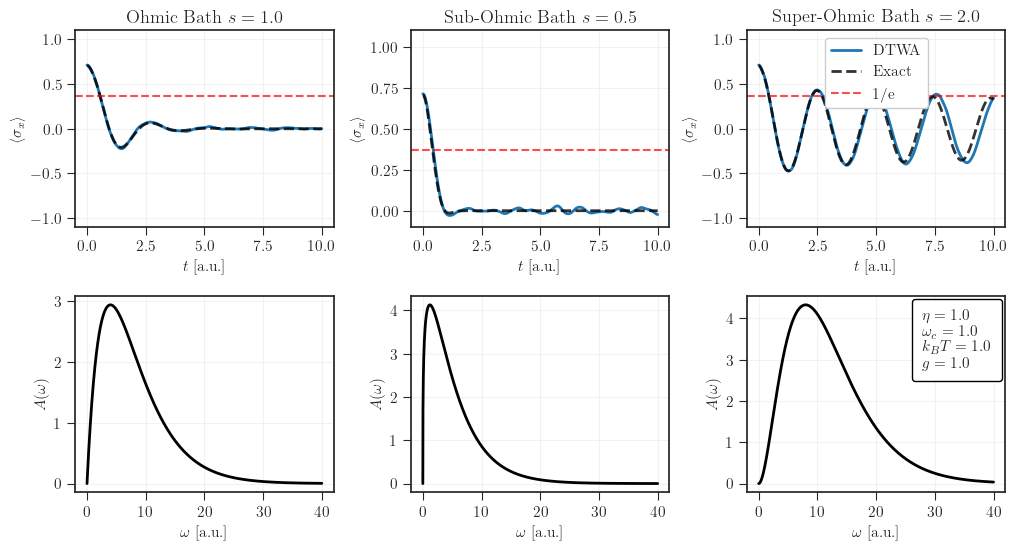

In [7]:
plt.style.use(['seaborn-v0_8-white', './style.mplstyle'])
fig, ax = plt.subplots(2,3, figsize=(12, 6))
plt.subplots_adjust(wspace=0.3, hspace=0.35)

decay_level = 1 / jnp.e  

# --- 2. The Parameter Box (White Background) ---
text_str = '\n'.join((
    r'$\eta = 1.0$',
    r'$\omega_c = 1.0$',
    r'$k_B T = 1.0$',
    r'$g = 1.0$'
))

# Option A: Using AnchoredText (Best for fixed corner placement)
at = AnchoredText(
    text_str, 
    loc='upper right',  # Changed to right to avoid covering the decay start
    prop=dict(size=11),
    frameon=True
)
at.patch.set_boxstyle("round,pad=0.3,rounding_size=0.2")
at.patch.set_facecolor('white') # Explicit white background
at.patch.set_edgecolor('black') # Thin black border
at.patch.set_alpha(1.0)         # Opaque (hides the line behind it)
ax[1,2].add_artist(at)

ax[0,0].plot(t_grid, mean_ohmic_trace[:,0], label = 'DTWA', linewidth = 2)
ax[0,0].plot(t_grid, exact_ohmic, label = 'Exact', linewidth = 2, linestyle = '--', color = 'k', alpha = 0.8)
ax[0,0].set_xlabel(r'$t$ [a.u.]')
ax[0,0].set_ylabel(r'$\langle \sigma_x \rangle$')
ax[0,0].grid(alpha = 0.25)
ax[0,0].set_title(r'Ohmic Bath $s=1.0$')
ax[0,0].set_ylim(bottom=-1.1, top=1.1)
ax[0,0].axhline(y=decay_level, color='red', linestyle='--', alpha=0.7, label='1/e')

ax[0,1].plot(t_grid, mean_sub_ohmic_trace[:,0], label = 'DTWA', linewidth = 2)
ax[0,1].plot(t_grid, exact_sub_ohmic, label = 'Exact', linewidth = 2, linestyle = '--', color = 'k', alpha = 0.8)
ax[0,1].set_xlabel(r'$t$ [a.u.]')
ax[0,1].grid(alpha = 0.25)
ax[0,1].set_ylabel(r'$\langle \sigma_x \rangle$')
ax[0,1].set_title(r'Sub-Ohmic Bath $s=0.5$')
ax[0,1].set_ylim(bottom=-0.1, top=1.1)
ax[0,1].axhline(y=decay_level, color='red', linestyle='--', alpha=0.7, label='1/e')

ax[0,2].plot(t_grid, mean_super_ohmic_trace[:,0], label = 'DTWA', linewidth = 2)
ax[0,2].plot(t_grid, exact_super_ohmic, label = 'Exact', linewidth = 2, linestyle = '--', color = 'k', alpha = 0.8)
ax[0,2].set_xlabel(r'$t$ [a.u.]')
ax[0,2].grid(alpha = 0.25)
ax[0,2].set_title(r'Super-Ohmic Bath $s=2.0$')
ax[0,2].set_ylabel(r'$\langle \sigma_x \rangle$')
ax[0,2].set_ylim(bottom=-1.1, top=1.1)
ax[0,2].axhline(y=decay_level, color='red', linestyle='--', alpha=0.7, label='1/e')
ax[0,2].legend()

ax[1,0].plot(omegas, ohmic_spectral_density, linewidth = 2, color = 'k')
ax[1,0].set_xlabel(r'$t$ [a.u.]')
ax[1,0].grid(alpha = 0.25)
ax[1,0].set_xlabel(r'$\omega$ [a.u.]')
ax[1,0].set_ylabel(r'$A(\omega)$')

ax[1,1].plot(omegas, sub_ohmic_spectral_density, linewidth = 2, color = 'k')
ax[1,1].set_xlabel(r'$t$ [a.u.]')
ax[1,1].grid(alpha = 0.25)
ax[1,1].set_xlabel(r'$\omega$ [a.u.]')
ax[1,1].set_ylabel(r'$A(\omega)$')

ax[1,2].plot(omegas, super_ohmic_spectral_density, linewidth = 2, color = 'k')
ax[1,2].set_xlabel(r'$t$ [a.u.]')
ax[1,2].grid(alpha = 0.25)
ax[1,2].set_xlabel(r'$\omega$ [a.u.]')
ax[1,2].set_ylabel(r'$A(\omega)$')

plt.savefig('non_markovian.png', dpi = 300)
plt.show()